# 划分训练集和测试集 

In [2]:
import glob
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms

In [6]:
all_imgs_path = glob.glob(r'../01计算机视觉基础/dataset2/*.jpg')

In [7]:
all_imgs_path[:5]

['../01计算机视觉基础/dataset2\\cloudy1.jpg',
 '../01计算机视觉基础/dataset2\\cloudy10.jpg',
 '../01计算机视觉基础/dataset2\\cloudy100.jpg',
 '../01计算机视觉基础/dataset2\\cloudy101.jpg',
 '../01计算机视觉基础/dataset2\\cloudy102.jpg']

## 创建一个乱序索引 

In [8]:
index = np.random.permutation(len(all_imgs_path))

In [9]:
 index

array([745, 519, 942, ..., 866, 186,  58])

In [10]:
all_imgs_path = np.array(all_imgs_path)[index]
all_imgs_path

array(['../01计算机视觉基础/dataset2\\shine80.jpg',
       '../01计算机视觉基础/dataset2\\shine104.jpg',
       '../01计算机视觉基础/dataset2\\sunrise258.jpg', ...,
       '../01计算机视觉基础/dataset2\\sunrise19.jpg',
       '../01计算机视觉基础/dataset2\\cloudy267.jpg',
       '../01计算机视觉基础/dataset2\\cloudy151.jpg'], dtype='<U36')

In [12]:
all_labels=[] 
species=['cloudy','rain','shine','sunrise']
for img in all_imgs_path: 
    for i,c in enumerate(species):
        if c in img:
            all_labels.append(i)
all_labels[:4] 

[2, 2, 3, 3]

In [13]:
all_imgs_path[:4]

array(['../01计算机视觉基础/dataset2\\shine80.jpg',
       '../01计算机视觉基础/dataset2\\shine104.jpg',
       '../01计算机视觉基础/dataset2\\sunrise258.jpg',
       '../01计算机视觉基础/dataset2\\sunrise163.jpg'], dtype='<U36')

经过对比发现labels和imgpath是对照的

## 进行数据集的划分 

In [14]:
s = int(len(all_imgs_path)*0.8) 
s 

897

### 构建训练集 

In [15]:
train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s] 

### 构建测试集 

In [16]:
test_imgs = all_imgs_path[s:] 
test_labels = all_labels[s:]

### 自定义dataset 

In [17]:
class myDataset(Dataset): 
    def __init__(self,img_path,labels,transforms): 
        self.img_path = img_path
        self.labels = labels
        self.transform = transforms
    def __len__(self): 
        return len(self.img_path) 
    def __getitem__(self,index):
        img_path = self.img_path[index]
        label= self.labels[index] #这样就得到了对应的图片路径和图片标签

        img = Image.open(img_path).convert('RGB')
        if self.transform: #如果有transform操作那就进行转换
            img = self.transform(img)
        return img,label

### 创建train_ds,test_ds 

In [18]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((96,96)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor()
        
    ]
)
train_ds = myDataset(train_imgs,train_labels,train_transforms)

In [33]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((96,96)),
        transforms.ToTensor(),
    ]
)
test_ds = myDataset(test_imgs,test_labels,test_transforms)

### 创建train_dl,test_dl 

In [34]:
train_dl = DataLoader(train_ds,shuffle=True,batch_size=64)
test_dl = DataLoader(test_ds,shuffle=False,batch_size=128)

### 定义训练函数 

In [35]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


### 定义模型 

In [25]:
import torchvision.models as models
import torch.nn as nn
import torchvision.models.resnet as resnet

In [24]:
model = models.resnet18(weights=resnet.ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
model.fc = nn.Linear(in_features=model.fc.in_features,out_features=4)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters(): 
    param.requires_grad = True

### 创建优化器和损失函数 

In [29]:
import torch

In [30]:
optimizer = torch.optim.Adam(model.fc.parameters(),lr=0.001) 
loss_fn = nn.CrossEntropyLoss() 

In [36]:
from torch.optim.lr_scheduler import StepLR 
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0
scheduler = StepLR(optimizer=optimizer,step_size=3,gamma=0.9) 
train_loss_gpu = [] 
train_acc_gpu = [] 
tst_loss_gpu = [] 
tst_acc_gpu = [] 
epochs = 10 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(
        Train_DL=train_dl, 
        TST_DL=test_dl, 
        Model_m=model, 
        epoch_=epoch, 
        optim=optimizer, 
        loss_fn=loss_fn
    )
    if tstepoch_acc>best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = tstepoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.017 | acc:0.575 | tstloss:0.009 | tstacc:0.676
Epoch 1: 学习率已更新为 1.00e-03
epoch:1 | loss:0.014 | acc:0.674 | tstloss:0.007 | tstacc:0.747
Epoch 2: 学习率已更新为 1.00e-03
epoch:2 | loss:0.014 | acc:0.722 | tstloss:0.007 | tstacc:0.760
Epoch 3: 学习率已更新为 9.00e-04
epoch:3 | loss:0.012 | acc:0.750 | tstloss:0.006 | tstacc:0.800
Epoch 4: 学习率已更新为 9.00e-04
epoch:4 | loss:0.010 | acc:0.835 | tstloss:0.006 | tstacc:0.809
Epoch 5: 学习率已更新为 9.00e-04
epoch:5 | loss:0.011 | acc:0.807 | tstloss:0.005 | tstacc:0.809
Epoch 6: 学习率已更新为 8.10e-04
epoch:6 | loss:0.010 | acc:0.822 | tstloss:0.005 | tstacc:0.827
Epoch 7: 学习率已更新为 8.10e-04
epoch:7 | loss:0.009 | acc:0.804 | tstloss:0.005 | tstacc:0.836
Epoch 8: 学习率已更新为 8.10e-04
epoch:8 | loss:0.009 | acc:0.851 | tstloss:0.005 | tstacc:0.853
Epoch 9: 学习率已更新为 7.29e-04
epoch:9 | loss:0.009 | acc:0.832 | tstloss:0.005 | tstacc:0.831
Epoch 10: 学习率已更新为 7.29e-04


In [37]:
best_acc

0.8533333333333334

### 解冻所有层,进入微调阶段 

In [38]:
for param in model.parameters(): 
    param.requires_grad = True

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 更小的学习率更适合微调

In [42]:

from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
# train_loss_gpu = []
# train_acc_gpu = []
# tst_loss_gpu = []
# tst_acc_gpu = []
ex_epochs = 10

for epoch in range(ex_epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=train_dl,
        TST_DL=test_dl,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = tstepoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.002 | acc:0.988 | tstloss:0.001 | tstacc:0.951
Epoch 1: 学习率已更新为 8.10e-05
epoch:1 | loss:0.002 | acc:0.994 | tstloss:0.001 | tstacc:0.964
Epoch 2: 学习率已更新为 8.10e-05
epoch:2 | loss:0.001 | acc:0.993 | tstloss:0.001 | tstacc:0.969
Epoch 3: 学习率已更新为 8.10e-05
epoch:3 | loss:0.002 | acc:0.991 | tstloss:0.001 | tstacc:0.960
Epoch 4: 学习率已更新为 8.10e-05
epoch:4 | loss:0.001 | acc:0.997 | tstloss:0.001 | tstacc:0.969
Epoch 5: 学习率已更新为 7.29e-05
epoch:5 | loss:0.001 | acc:0.994 | tstloss:0.001 | tstacc:0.969
Epoch 6: 学习率已更新为 7.29e-05
epoch:6 | loss:0.002 | acc:0.993 | tstloss:0.001 | tstacc:0.969
Epoch 7: 学习率已更新为 7.29e-05
epoch:7 | loss:0.001 | acc:0.994 | tstloss:0.001 | tstacc:0.960
Epoch 8: 学习率已更新为 7.29e-05
epoch:8 | loss:0.004 | acc:0.996 | tstloss:0.001 | tstacc:0.969
Epoch 9: 学习率已更新为 7.29e-05
epoch:9 | loss:0.001 | acc:0.997 | tstloss:0.001 | tstacc:0.978
Epoch 10: 学习率已更新为 6.56e-05


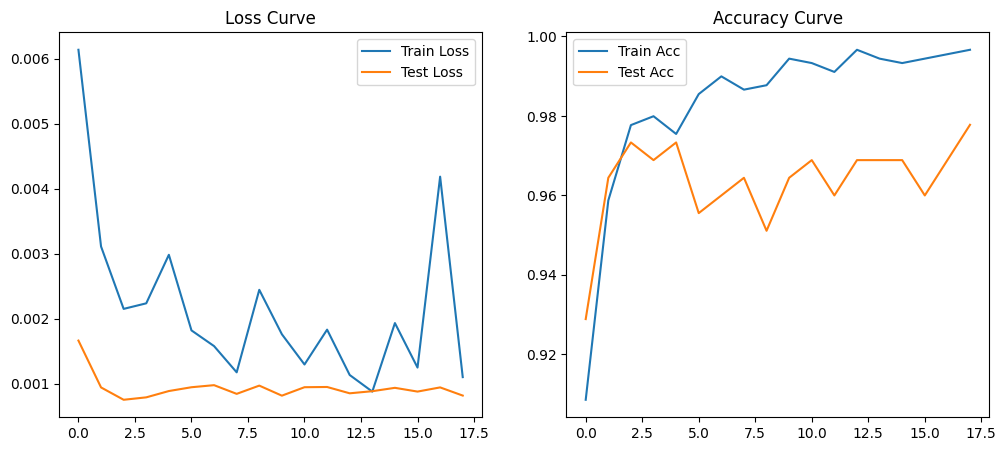

In [43]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

### 保存为torchscript格式并进行迁移学习

In [46]:
# 确保模型在评估模式
model.eval()

# 设置为 GPU 模式（如果你使用了 CUDA）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 创建一个示例输入，并放到与模型相同的设备上
example_input = torch.rand(1, 3, 96, 96).to(device)

# 使用 trace 跟踪模型行为
traced_script_module = torch.jit.trace(model, example_input)

# 保存为 .pt 文件
traced_script_module.save("./models/weather_classifier.pt")

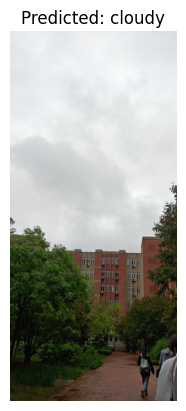

预测天气为: cloudy


In [50]:
from PIL import Image
import matplotlib.pyplot as plt
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']
# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=torch.jit.load('./models/weather_classifier.pt',map_location=device)



model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
 [
        transforms.Resize((96,96)),
        transforms.ToTensor()
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250517-081628.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)
# 将输入数据移动到相同的设备上
image_tensor = image_tensor.to(device)
# 推理
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_class = class_names[predicted_idx.item()]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

### 转换成onnx 

In [54]:
import torch

# 加载 TorchScript 模型
model = torch.jit.load('./models/weather_classifier.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# 设置模型为评估模式
model.eval()

# 创建一个示例输入张量，确保其尺寸与训练时一致
example_input = torch.randn(1, 3,96, 96).to(device)

# 导出模型为 ONNX 格式
torch.onnx.export(model,
                  example_input,  # 模型的输入 (或者一个元组对于多输入模型)
                  "./models/weather_classifier.onnx",  # 输出的 ONNX 文件名
                  input_names=["input"],  # 输入的名字
                  output_names=["output"],  # 输出的名字
                  opset_version=11,  # ONNX 版本，根据你的需求调整
                  dynamic_axes={'input': {0: 'batch_size'},  # 动态轴设置，这里设置了 batch_size 可变
                                'output': {0: 'batch_size'}})

print("模型已成功导出为 ONNX 格式")

D:\venvs\dl\Lib\site-packages\torch\onnx\utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x00000165D839C390>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


模型已成功导出为 ONNX 格式


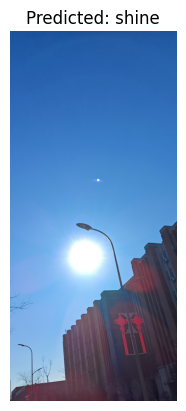

预测天气为: shine


In [55]:
import numpy as np 
import onnxruntime as ort
from PIL import Image
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']

# 加载 ONNX 模型
ort_session = ort.InferenceSession("./models/weather_classifier.onnx")

model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
    [
        transforms.Resize((96,96)),
        transforms.ToTensor()
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250329-081002.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)

image_np = image_tensor.numpy() # ONNX Runtime 接受 numpy 输入


# 推理
outputs = ort_session.run(
    None,
    {'input': image_np}  # 'input' 是导出时定义的输入名称
)

# 解析输出结果
predicted_idx = np.argmax(outputs[0], axis=1)[0]  # 获取预测类别索引
predicted_class = class_names[predicted_idx]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

## 灵活的使用dataset类构建输入

In [56]:
imgs,labels = next(iter(train_dl))

In [57]:
imgs.shape

torch.Size([64, 3, 96, 96])

假如说要将channel放到后面(如tensorflow),该怎么办呢?  
我们只需要子类化即可

In [58]:
class customized_dataset(Dataset): 
    def __init__(self,dataset): 
        self.dataset = dataset 
    def __getitem__(self,index): 
        newimg,newlabel= self.dataset[index]
        newimg = newimg.permute(1,2,0) #这样就是(w,h,c) 
        return newimg,newlabel 
    def __len__(self): 
        return len(self.dataset)  

In [59]:
train_new_ds = customized_dataset(train_ds)

In [61]:
newimg,newlabel = train_new_ds[2]

In [62]:
newimg.shape

torch.Size([96, 96, 3])

In [63]:
newlabel

3